## Create movies of detection

In [1]:
import bottleneck as bn
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt  # change point detection library
from matplotlib import animation

import dupin as du

FILENAME = "signal.npy"

In [2]:
signal = np.load("signal.npy")
smoothed_signal = bn.move_mean(signal, 3, 1, axis=0)

In [5]:
dynp = rpt.Dynp(custom_cost=du.detect.CostLinearFit())
sweep_detector = du.detect.SweepDetector(dynp, max_change_points=12)
change_points = sweep_detector.fit(signal)

In [6]:
change_points

[25, 55, 65, 70, 75, 80, 85, 95]

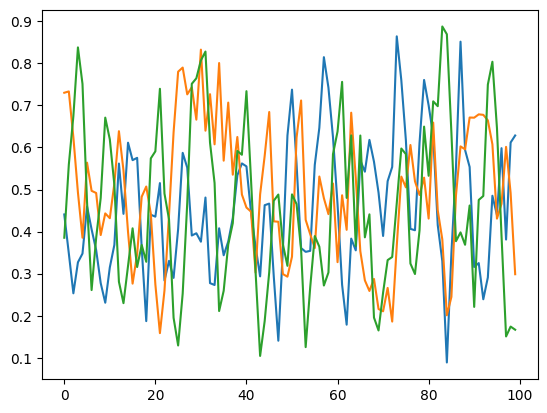

In [7]:
plt.plot(smoothed_signal)

## Signal

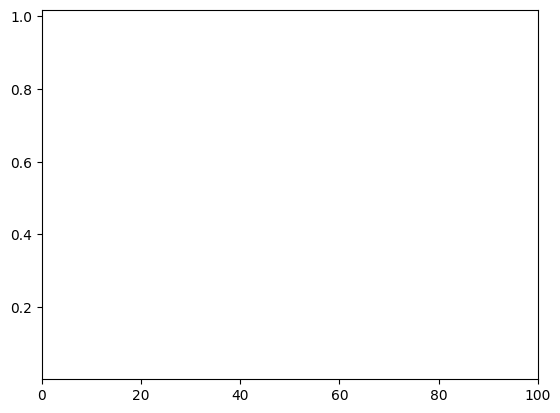

In [8]:
colors = ["c", "m", "y", "k"]
markers = [".", "o", "v", "^", "s"]


def init_detection():
    ax.set_ylim(signal.min() * 1.02, signal.max() * 1.02)
    ax.set_xlim(0, len(signal))
    for line in lines:
        line.set_data([], [])
    for point_set in points:
        point_set.set_data([], [])
    return artists


def run(frame):
    for i, line in enumerate(lines):
        line.set_data(frames[:frame], smoothed_signal[:frame, i])
    for i, point_set in enumerate(points[: signal.shape[1]]):
        point_set.set_data(frames[:frame], signal[:frame, i])
    if frame in change_points:
        vline = ax.axvline(frame, linestyle="--", color="black")
        return [*artists, vline]
    return artists


fig, ax = plt.subplots()
lines = [
    ax.plot([], [], lw=2, color=colors[i])[0] for i in range(signal.shape[1])
]
points = [
    ax.plot(
        [],
        [],
        linestyle="none",
        marker=markers[i],
        markerfacecolor=colors[i],
        markeredgecolor=colors[i],
    )[0]
    for i in range(signal.shape[1])
]
frames = np.arange(len(signal))
artists = lines + points
anim = animation.FuncAnimation(
    fig, run, frames=len(signal), init_func=init_detection, blit=True
)

In [9]:
anim.save("detect.gif")

In [10]:
plt.close(fig)

## System

In [2]:
import fresnel
import gsd.hoomd
import numpy as np

In [42]:
def init(N):
    device = fresnel.Device()
    scene = fresnel.Scene(device)
    scene.lights = fresnel.light.cloudy()
    scene.camera.look_at = [0, 0, 0]

    geometry = fresnel.geometry.Sphere(
        scene, N=N, radius=0.5, outline_width=0.05
    )
    geometry.material = fresnel.material.Material(roughness=1.2, specular=0.5)
    geometry.material.primitive_color_mix = 1.0
    tracer = fresnel.tracer.Preview(device, 600, 600)
    return tracer, scene, geometry


def render_traj(tracer, scene, geometry, traj):
    for snap in traj:
        geometry.position[:] = snap.particles.position
        scene.camera = fresnel.camera.Orthographic.fit(scene)
        yield tracer.render(scene)


def vec_dot(x, y):
    return np.sum(x * y).sum(axis=-1)


def vec_angle(x, y):
    return np.arccos(vec_dot(x, y) / np.sqrt(vec_dot(x, x) * vec_dot(y, y)))


def rotate(tracer, scene, axis, frames=24):
    cam_pos = np.asarray(scene.camera.position)
    pos_mask = np.arange(3) != axis
    xp = cam_pos[pos_mask]
    r = np.sqrt(vec_dot(xp, xp))
    thetas = np.linspace(0, 2 * np.pi, frames + 1, endpoint=True)[1:]
    thetas += np.arccos(xp[0] / r)
    points = np.stack((r * np.cos(thetas), r * np.sin(thetas)), axis=-1)
    for point in points:
        cam_pos[pos_mask] = point
        print(cam_pos)
        scene.camera.position = cam_pos
        yield tracer.render(scene)


def save_images(filename, images):
    dpi = 80
    pixel_count = images[0].shape[:2]
    figsize = tuple(i / dpi for i in pixel_count)
    fig = plt.Figure(figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labeltop=False,
        labelleft=False,
        labelright=False,
    )
    ims = []
    for image in images:
        ims.append([ax.imshow(image, aspect="equal", animated=True)])

    anim = animation.ArtistAnimation(fig, ims, blit=True)
    anim.save(filename)

In [43]:
images = []
with gsd.hoomd.open("lj-sim.gsd", "rb") as traj:
    tracer, scene, geometry = init(len(traj[-1].particles.position))
    geometry.color[:] = fresnel.color.linear([1.0, 0.25, 0.5])
    images.extend(
        img[:] for img in render_traj(tracer, scene, geometry, traj[-1:])
    )
    images.extend(img[:] for img in rotate(tracer, scene, 2, 30))
save_images("lj-sim.mp4", images)

[3.8085942 5.8721747 4.955125 ]
[2.5044734 6.5357046 4.955125 ]
[1.0908953 6.9135933 4.955125 ]
[-0.37036029  6.9893246   4.955125  ]
[-1.8154293  6.7595887  4.955125 ]
[-3.1811554  6.2344265  4.955125 ]
[-4.40785   5.43679   4.955125]
[-5.4419    4.40154   4.955125]
[-6.238113   3.1739209  4.955125 ]
[-6.76169    1.8075866  4.955125 ]
[-6.9897494   0.36225194  4.955125  ]
[-6.912323  -1.0989147  4.955125 ]
[-6.532795  -2.5120537  4.955125 ]
[-5.8677526 -3.8154037  4.955125 ]
[-4.946261  -4.9520025  4.955125 ]
[-3.8085942 -5.8721747  4.955125 ]
[-2.5044734 -6.5357046  4.955125 ]
[-1.0908953 -6.9135933  4.955125 ]
[ 0.37036029 -6.9893246   4.955125  ]
[ 1.8154293 -6.7595887  4.955125 ]
[ 3.1811554 -6.2344265  4.955125 ]
[ 4.40785  -5.43679   4.955125]
[ 5.4419   -4.40154   4.955125]
[ 6.238113  -3.1739209  4.955125 ]
[ 6.76169   -1.8075866  4.955125 ]
[ 6.9897494  -0.36225194  4.955125  ]
[6.912323  1.0989147 4.955125 ]
[6.532795  2.5120537 4.955125 ]
[5.8677526 3.8154037 4.955125 ]
[4.

In [39]:
save_images("lj-sim.mp4", images)